In [12]:
using ModelingToolkit, Sophon, DomainSets
using Optimization, OptimizationOptimJL

@parameters t, x
@variables u(..)
Dt = Differential(t)
Dx = Differential(x)
Dxx = Differential(x)^2

r1 = 0.02
r2 = 1

eq = Dt(u(t, x)) - Dxx(r2*(u(t,x)^3 - u(t,x)) - r1 * Dxx(u(t,x))) ~ 0.0

bcs = [u(0, x) ~ cospi(x)-exp(-4*π*π*abs2(x)),
    u(t, -1.0) ~ u(t, 1.0),
    Dx(u(t, -1.0)) ~ Dx(u(t, 1.0))]

domains = [t ∈ Interval(0.0, 1.0),
    x ∈ Interval(-1.0, 1.0)]

@named pde_system = PDESystem(eq, bcs, domains, [t,x], [u(t,x)])

PDESystem
Equations: Equation[Differential(t)(u(t, x)) - Differential(x)(Differential(x)(u(t, x)^3 - 0.02Differential(x)(Differential(x)(u(t, x))) - u(t, x))) ~ 0.0]
Boundary Conditions: Equation[u(0, x) ~ cospi(x) - exp(-39.47841760435743abs2(x)), u(t, -1.0) ~ u(t, 1.0), Differential(x)(u(t, -1.0)) ~ Differential(x)(u(t, 1.0))]
Domain: Symbolics.VarDomainPairing[Symbolics.VarDomainPairing(t, 0.0..1.0), Symbolics.VarDomainPairing(x, -1.0..1.0)]
Dependent Variables: Num[u(t, x)]
Independent Variables: Num[t, x]
Parameters: SciMLBase.NullParameters()
Default Parameter ValuesDict{Any, Any}()

In [13]:
chain = FullyConnected(2, 1, tanh; hidden_dims=16, num_layers=5)
pinn = PINN(chain)
sampler = BetaRandomSampler(2000, (400, 100, 100))
strategy = NonAdaptiveTraining(1, (500,10,10))
prob = Sophon.discretize(pde_system, pinn, sampler, strategy)

OptimizationProblem. In-place: true
u0: ComponentVector{Float64}(layer_1 = (weight = [-1.6757299900054932 -1.2930316925048828; 1.3719240427017212 -1.5787341594696045; … ; 0.5492261648178101 -0.722214937210083; -1.584168553352356 -1.7561231851577759], bias = [0.0; 0.0; … ; 0.0; 0.0;;]), layer_2 = (weight = [-0.6086887121200562 -0.454514741897583 … 0.2986176311969757 -0.29712530970573425; 0.40014025568962097 0.49458417296409607 … -0.2874128520488739 0.2896574139595032; … ; 0.16005226969718933 0.5456894040107727 … 0.29291000962257385 0.6540327668190002; 0.5653309226036072 -0.5591045618057251 … 0.3629484176635742 0.24676121771335602], bias = [0.0; 0.0; … ; 0.0; 0.0;;]), layer_3 = (weight = [-0.24727793037891388 0.47391277551651 … 0.0715097039937973 0.7117019295692444; -0.2926873564720154 0.34177476167678833 … 0.22349321842193604 -0.3854007422924042; … ; -0.5870818495750427 -0.6454070210456848 … 0.5612911581993103 -0.22713959217071533; 0.273404598236084 0.16006173193454742 … 0.1511847823858

In [14]:
i = 0
function callback(p, l)
    global i
    i%100==0 && println("Loss: $l")
    i += 1
    return false
end

res = Optimization.solve(prob, BFGS(); maxiters=1000, callback=callback)

Loss: 33338.93281050941


Loss: 7.4983611031651884


Loss: 4.106213657673924


Loss: 1.6391662600270327


Loss: 0.6049861532763718


Loss: 0.1941096295738461


Loss: 0.08457629641815147


Loss: 0.043256087758139064


Loss: 0.02463907574403974


Loss: 0.01386552465964594


Loss: 0.008562297302998782


u: ComponentVector{Float64}(layer_1 = (weight = [-5.076195690920549 -0.8129524735196962; 3.1198972591066525 -0.9335865282120306; … ; -0.15949102585890115 -0.8645332091292719; -1.6819777453636686 -1.5815573226418294], bias = [-0.2586619337781622; 0.5835381279841908; … ; -0.8339275499035826; 0.0995424807104193;;]), layer_2 = (weight = [-2.2469853842832417 -0.8149771295934037 … 1.0892960796688866 0.12475735349614239; 0.5744871129252874 1.1452375880565913 … -1.814749964550135 0.07520327912603521; … ; -1.8708661885532403 3.2613173073413484 … 0.45923953700761394 -1.6879534931493902; -0.09587397588128754 -1.425570255421399 … 0.09548472337249184 -0.048427041192326006], bias = [0.7061487429653036; -0.8093586849957877; … ; -0.46184373907972226; 0.4100262241314994;;]), layer_3 = (weight = [-0.8607275311896488 0.6110303737849427 … 1.189383882315142 1.3373926706553043; -1.5244032728233874 0.6927487953295953 … 0.4447009420491778 0.24437300007060322; … ; -1.3562402351836849 -0.2945920619442808 … 0.56

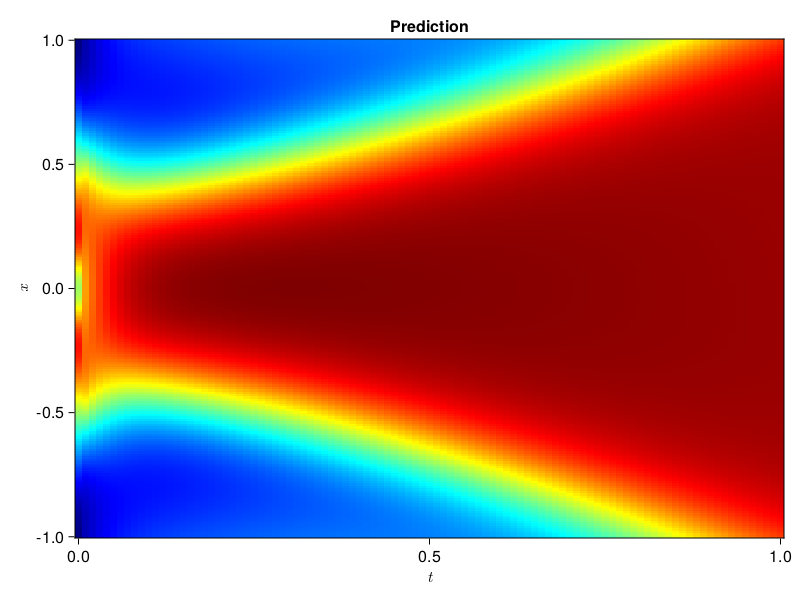

In [15]:
using CairoMakie, MakiePublication

phi = pinn.phi
ts, xs = [infimum(d.domain):0.01:supremum(d.domain) for d in pde_system.domain]
axis = (xlabel=L"t", ylabel=L"x", title="Prediction")
u_pred = [sum(pinn.phi([t, x], res.u)) for t in ts, x in xs]
heatmap(ts, xs, u_pred, axis=axis, colormap=:jet)

Loss: 0.027020310443307848


Loss: 0.006485817151414628


Loss: 0.003503776196390696


Loss: 0.001716331304739425


Loss: 0.0010864454716710682


Loss: 0.0007314713510927297


Loss: 0.00047156376684614283


Loss: 0.0003162900851544312


Loss: 0.00022692741995272652


Loss: 0.0001646499568786635


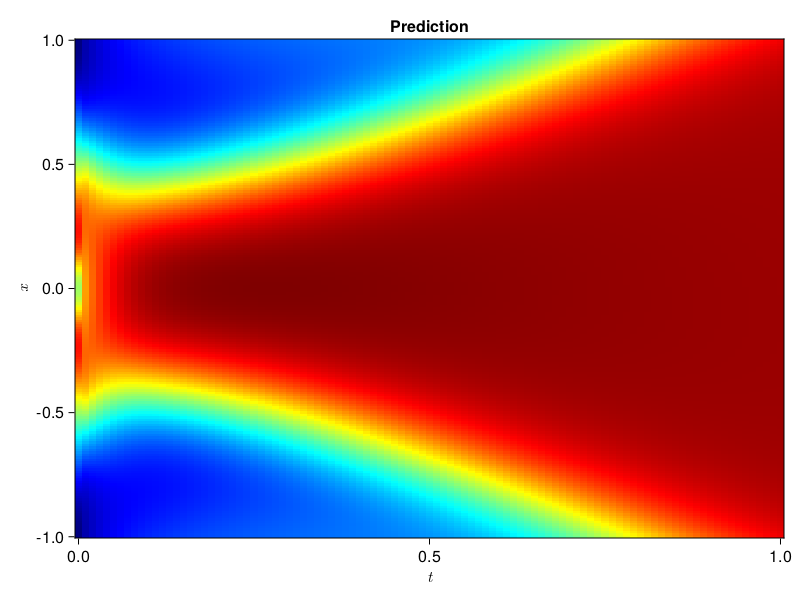

Loss: 0.0001235041447640767


Loss: 0.3059656211260525


Loss: 0.0055738036425842085


Loss: 0.00018620608606578258


Loss: 8.140627694633061e-5


Loss: 5.252860055337357e-5


Loss: 3.7675988224307e-5


Loss: 2.8095284610471642e-5


Loss: 2.1295560436511606e-5


Loss: 1.7173147684210692e-5


Loss: 1.42841327895579e-5


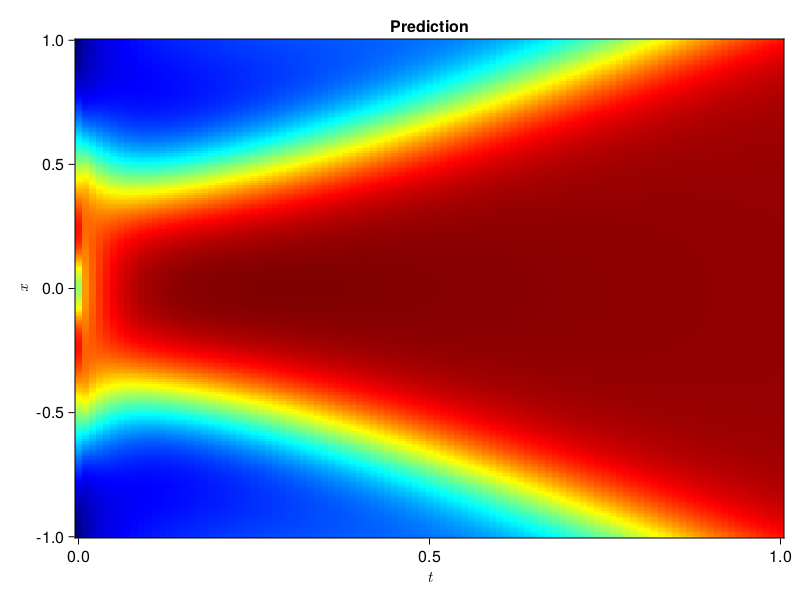

Loss: 1.1854150399472206e-5


Loss: 0.37777264671508515


Loss: 0.0006187179457104232


Loss: 2.075750984886089e-5


Loss: 1.0161784719175587e-5


In [16]:
for α in [0.5, 0.6, 0.8, 1.0] 
    i = 0
    sampler = remake(sampler; α=α)
    data = Sophon.sample(pde_system, sampler)
    prob = remake(prob; p=data, u0=res.u)
    res = Optimization.solve(prob, BFGS(); maxiters=1000, callback=callback)

    u_pred = [sum(pinn.phi([t, x], res.u)) for t in ts, x in xs]
    fig, ax, hm = heatmap(ts, xs, u_pred, axis=axis, colormap=:jet)
    display(fig)
end

In [ ]:
using JLD2
jldsave("cahn-hilliard_finitediff.jld2"; pde=pde_system, pinn=pinn, res=res, prob=prob)

# Improve accuracy with taylordiff

In [ ]:
using TaylorDiff
prob = Sophon.discretize(pde_system, pinn, sampler, strategy; derivative=Sophon.taylordiff)
prob = remake(prob; u0=res.u)
i=0
res2 = Optimization.solve(prob, BFGS(); maxiters=1000, callback=callback)

In [ ]:
phi = pinn.phi
ts, xs = [infimum(d.domain):0.01:supremum(d.domain) for d in pde_system.domain]
axis = (xlabel=L"t", ylabel=L"x", title="Prediction")
u_pred = [sum(pinn.phi([t, x], res.u)) for t in ts, x in xs]
heatmap(ts, xs, u_pred, axis=axis, colormap=:jet)

In [ ]:
using JLD2
jldsave("cahn-hilliard_finitediff_taylordiff.jld2"; pde=pde_system, pinn=pinn, res=res2, prob=prob)